<a href="https://colab.research.google.com/github/imharrisonlin/NYC_BikeShare_Weather_Analysis/blob/main/Clean_Bike_Share.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Motivation

The New York CitiBike share scheme (NYC Bikes) is one of the world’s largest, and data about bike usage is publicly available.  Analysis of this data therefore represents a ‘big data’ challenge with 33 million rows of data. 
We set out to explore the relationship with between Bike usage and the Weather in NYC over the first five months of 2018.  


## Datasets

### NYC CITI Bike

**Description:** The bike share scheme has 10,000 bikes and 600 bike stations. The data set started in 2013 and continues to receive daily updates. It is a public data set hosted in Google BigQuery.

**Size:** The dataset had 33,319,019 records as at 6 April 2021. It has 16 columns related to bike hires such as start/stop time, location and user data. 

**Format:**  GoogleBigQuery is a database that can be explored with SQL. The data is tabular with clear given data types (integer, string, datetime and so on).
 
**Access method:**  Query results can be exported as CSV/JSON and is also accessible via an API.


### NYC Weather Data

**Description:** Weather data is available from 1901 to present day, provided by National Oceanic and Atmospheric Administration (NOAA) . The weather dataset can be accessed from the NOAA department of the National Center for Environmental Information archive. The key features of interest are the climate and temperature experienced during a given timeframe, in order to correlate it to the bike share data for user behavior analysis. (ex. Manhattan Station: GHCND:US1NYNY0074)

**Size:** The dataset had 411,264 records from 2013-2020, when accessed. It contains 34 weather related features such as temperature, lat/long coordinates, precipitation.

**Format:** The dataset is in CSV format consisting of integer, string, and datetime data types.

**Access method:** We used an online query search is available for dataset requests, filtering features, location and date ranges. The results can be exported as CSV or Excel data and are also accessible via an API.

# Import necessary packages

In [122]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import altair as alt 
import ipywidgets as widgets
from IPython.display import display
import folium
import seaborn as sns 

from sklearn.preprocessing import MinMaxScaler

# 1.Initial connection to gcp postgres database

In [ ]:
# gcloud login and check the DB
!gcloud auth login
!gcloud config set project 'm1-bike-share-nyc-postgres' #[YOUR PROJECT ID]
!gcloud sql instances describe 'postgresql-nyc-bike-share-m1' #[YOUR CLOUDSQL INSTANCE ID]

In [ ]:
# download and initialize the psql proxy
!wget https://dl.google.com/cloudsql/cloud_sql_proxy.linux.amd64 -O cloud_sql_proxy
!chmod +x cloud_sql_proxy
# "connectionName" is from the previous block
!nohup ./cloud_sql_proxy -instances="m1-bike-share-nyc-postgres:us-central1:postgresql-nyc-bike-share-m1"=tcp:5432 &
!sleep 30s

In [ ]:
!cat nohup.out #useful for checking proxy log

In [135]:
def connection_cursor():
  conn = psycopg2.connect(
            host='127.0.0.1', port='5432', database='nycBikes',
            user='postgres', password='PostgresPassword')
  return conn.cursor()

# 2.Looking at route pairs

## 2.1 Analyzing route pairs and bike count

In [ ]:
cursor = connection_cursor()
route_pair_query = '''
  SELECT (start_station_name, end_station_name) as route_pair, count(*) as route_counts
  FROM bikes
  GROUP BY route_pair
  ORDER BY route_counts DESC
'''

cursor.execute(route_pair_query)
route_pair_data = cursor.fetchall()
route_pair_df = pd.DataFrame(route_pair_data)
route_pair_df.columns = ["Tuple of route pair","Number of bikes hired"]
route_pair_df.head()

,Tuple of route pair,Number of bikes hired
0,"(""E 7 St & Avenue A"",""Cooper Square & Astor Pl"")",3116
1,"(""Central Park S & 6 Ave"",""Central Park S & 6 ...",2071
2,"(""Grand Army Plaza & Central Park S"",""Grand Ar...",1874
3,"(""S 4 St & Wythe Ave"",""N 6 St & Bedford Ave"")",1835
4,"(""Central Park S & 6 Ave"",""5 Ave & E 88 St"")",1833


The row below slices the pairs - reccomend starting with 500 (ie 0:499) then using a small number for Viz of network

In [ ]:
len(route_pair_df)

245068

In [ ]:
copy = route_pair_df.loc[:49] #slice for Altair the top 500 routes with c.more than 500 rides

In [ ]:
alt.Chart(copy).mark_bar().encode(
    alt.X('Tuple of route pair:N', sort='-y'),
    alt.Y('Number of bikes hired:Q')
)

alt.Chart(...)

## 2.2 Looking a high density route pair data: route 68

### 2.2.1 Route 68: Querying the route data and preparing initial EDA

In [6]:
cursor = connection_cursor()

In [104]:
route68query = ''' 
SELECT *
FROM bikes
WHERE start_station_name = 'E 47 St & Park Ave' AND end_station_name = 'W 41 St & 8 Ave'
;

'''


In [105]:
cols = ['tripduration', 'starttime' ,'stoptime' ,'start_station_id' ,'start_station_name' ,'start_station_latitude' ,
'start_station_longitude' ,'end_station_id' ,'end_station_name' ,'end_station_latitude' ,'end_station_longitude' ,
'bikeid' ,'usertype'  ,'birth_year' ,'gender' ,'customer_plan'  ]

In [106]:
cursor.execute(route68query)
r68 = cursor.fetchall()
r68df = pd.DataFrame(r68, columns = cols)
r68df.head()

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,customer_plan
0,437,2018-02-14 10:10:57.508,2018-02-14 10:18:15.111,359,E 47 St & Park Ave,40.755104,-73.97498,477,W 41 St & 8 Ave,40.756405,-73.99003,27048,Subscriber,1987,male,None
1,574,2018-02-14 10:13:47.322,2018-02-14 10:23:22.060,359,E 47 St & Park Ave,40.755104,-73.97498,477,W 41 St & 8 Ave,40.756405,-73.99003,31531,Subscriber,1964,male,None
2,323,2018-02-14 16:18:45.264,2018-02-14 16:24:08.894,359,E 47 St & Park Ave,40.755104,-73.97498,477,W 41 St & 8 Ave,40.756405,-73.99003,32409,Subscriber,1971,male,None
3,424,2018-02-14 16:27:08.007,2018-02-14 16:34:12.512,359,E 47 St & Park Ave,40.755104,-73.97498,477,W 41 St & 8 Ave,40.756405,-73.99003,31589,Subscriber,1973,male,None
4,569,2018-02-14 17:12:06.155,2018-02-14 17:21:35.869,359,E 47 St & Park Ave,40.755104,-73.97498,477,W 41 St & 8 Ave,40.756405,-73.99003,21588,Subscriber,1987,male,None


In [107]:
r68df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 988 entries, 0 to 987
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   tripduration             988 non-null    int64         
 1   starttime                988 non-null    datetime64[ns]
 2   stoptime                 988 non-null    datetime64[ns]
 3   start_station_id         988 non-null    int64         
 4   start_station_name       988 non-null    object        
 5   start_station_latitude   988 non-null    float64       
 6   start_station_longitude  988 non-null    float64       
 7   end_station_id           988 non-null    int64         
 8   end_station_name         988 non-null    object        
 9   end_station_latitude     988 non-null    float64       
 10  end_station_longitude    988 non-null    float64       
 11  bikeid                   988 non-null    int64         
 12  usertype                 988 non-nul

In [108]:
r68df.describe()

,tripduration,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,birth_year
count,988.000000,988.0,9.880000e+02,9.880000e+02,988.0,9.880000e+02,9.880000e+02,988.000000,988.000000
mean,509.358300,359.0,4.075510e+01,-7.397498e+01,477.0,4.075641e+01,-7.399003e+01,25422.618421,1974.426113
std,159.096936,0.0,5.260679e-13,6.398123e-13,0.0,7.819929e-14,7.393387e-13,6247.387226,11.179189
min,288.000000,359.0,4.075510e+01,-7.397498e+01,477.0,4.075641e+01,-7.399003e+01,14573.000000,1946.000000
25%,424.000000,359.0,4.075510e+01,-7.397498e+01,477.0,4.075641e+01,-7.399003e+01,19075.750000,1964.000000
50%,480.000000,359.0,4.075510e+01,-7.397498e+01,477.0,4.075641e+01,-7.399003e+01,27082.000000,1974.500000
75%,558.250000,359.0,4.075510e+01,-7.397498e+01,477.0,4.075641e+01,-7.399003e+01,31091.500000,1986.000000
max,2366.000000,359.0,4.075510e+01,-7.397498e+01,477.0,4.075641e+01,-7.399003e+01,33469.000000,1995.000000


### 2.2.2 Route 68: Analysis and visualization of bike ride data

In [109]:
def plotCorrelationMatrix(df, graphWidth, filename=''):
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [110]:
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef =\n %.3f' % corrs[i, j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center', size=10)
    plt.suptitle('Scatter and Density Plot', fontsize=20)
    
    #y ticklabels
    [plt.setp(item.yaxis.get_majorticklabels(), 'size', 10) for item in ax.ravel()]
    #x ticklabels
    [plt.setp(item.xaxis.get_majorticklabels(), 'size', 10) for item in ax.ravel()]
    #y labels
    [plt.setp(item.yaxis.get_label(), 'size', 15) for item in ax.ravel()]
    #x labels
    [plt.setp(item.xaxis.get_label(), 'size', 15) for item in ax.ravel()]

    plt.show()

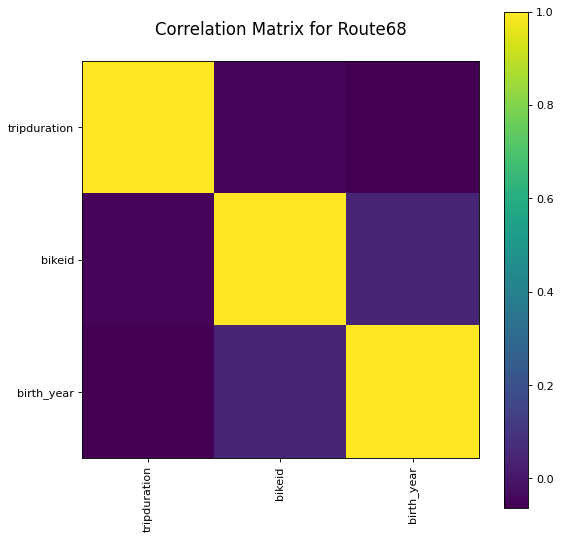

In [111]:
plotCorrelationMatrix(r68df, 8, 'Route68')

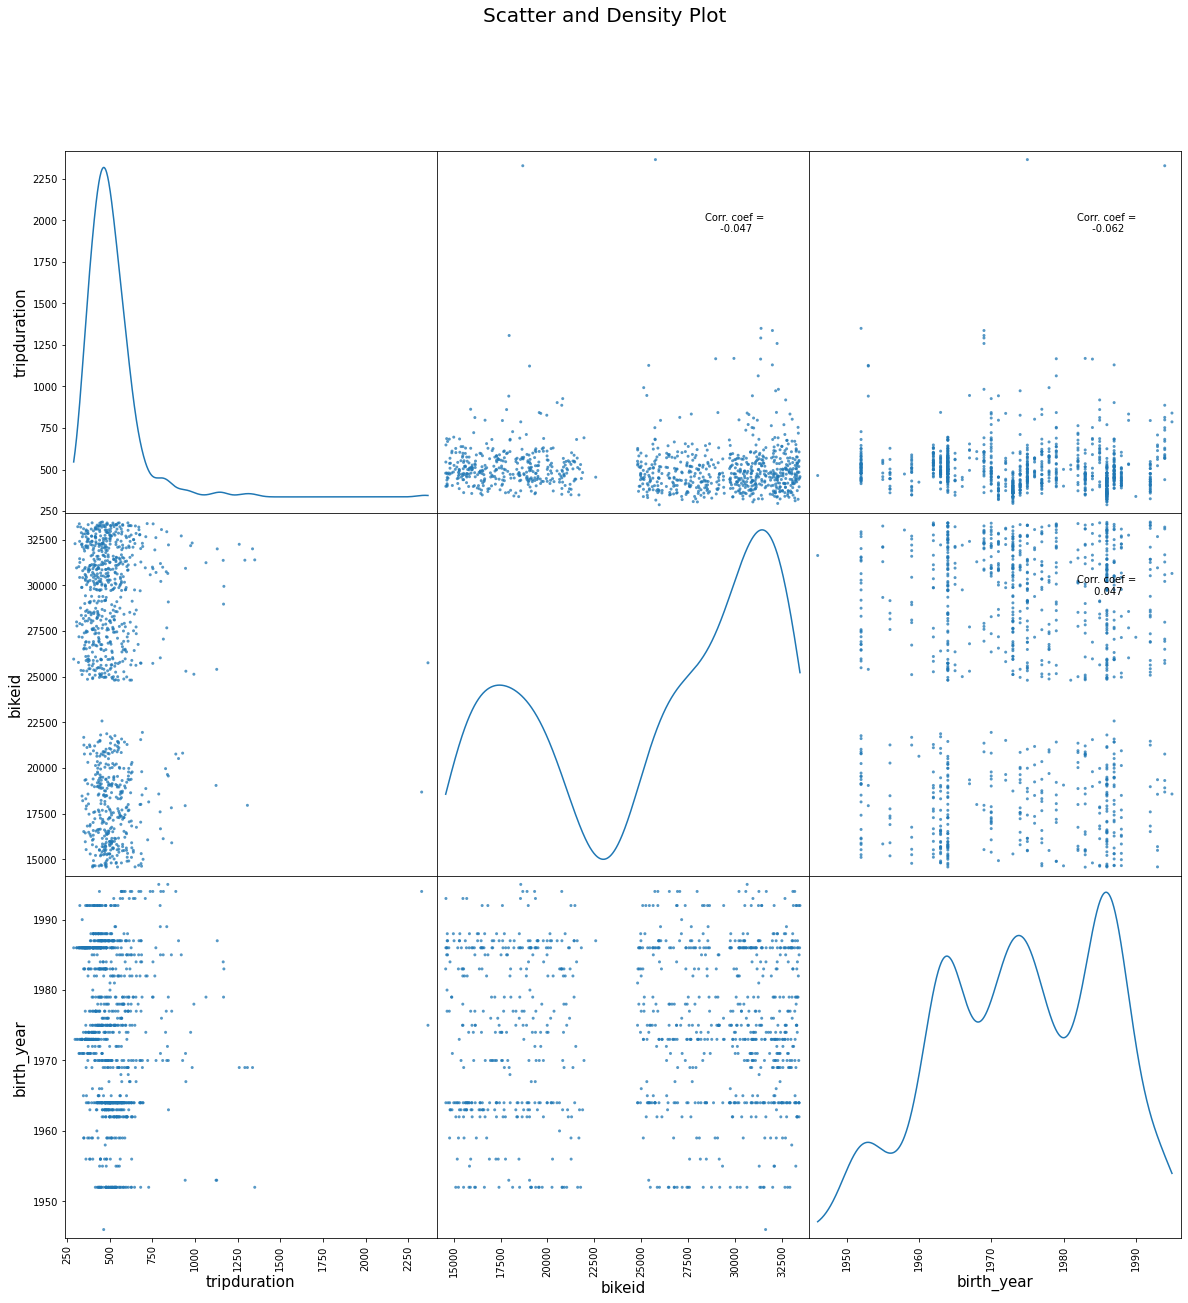

In [112]:
plotScatterMatrix(r68df, 20, 10)

* Above shows most rides born in the 1990s, with a bi-modal peak between 1960s-1970s

*   Bike ids dont tell us much
*   Mostly shorter trips on this route, skewed with a long tail
* Be interesting to repeat this plot with **weather** data





In [113]:
r68df.isnull().sum() #Good to see zero null values - for SNS SPLOM

tripduration                 0
starttime                    0
stoptime                     0
start_station_id             0
start_station_name           0
start_station_latitude       0
start_station_longitude      0
end_station_id               0
end_station_name             0
end_station_latitude         0
end_station_longitude        0
bikeid                       0
usertype                     0
birth_year                   0
gender                       0
customer_plan              988
dtype: int64

- Standard seaborn pairplot doesnt say much given start/stops etc are fixed. 
- Note zero **customer plan** values on this route - perhaps none in the whole df.

In [114]:
pairDF = r68df.drop(columns = ['start_station_id' ,'start_station_name' ,'start_station_latitude' ,
'start_station_longitude' ,'end_station_id' ,'end_station_name' ,'end_station_latitude' ,'end_station_longitude','customer_plan'])

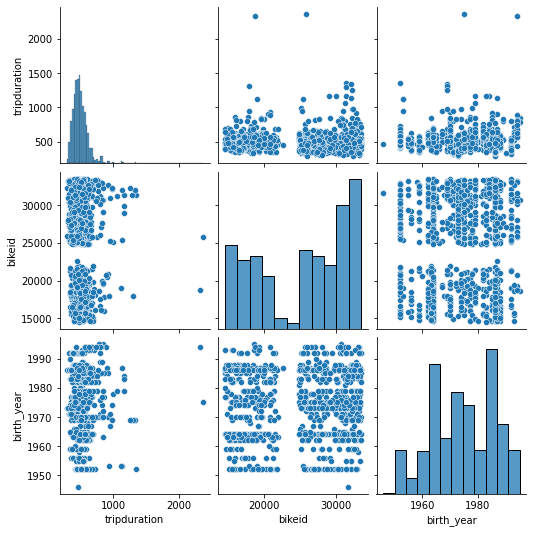

In [115]:
sns.pairplot(pairDF)

In [116]:
#trip duration is most interesting perhaps
alt.Chart(pairDF).mark_circle(opacity=.5).encode(
    alt.X('tripduration:Q', title='Trip Duration (s)'),
    alt.Y('count()')
)

alt.Chart(...)

In [117]:
alt.Chart(r68df).mark_circle(opacity=.2).encode(
    alt.X('tripduration:Q', title='Trip Duration (s)'),
    alt.Y('starttime:T', title = None)
)

alt.Chart(...)

In [118]:
start_location = (r68df['start_station_latitude'][0], r68df['start_station_longitude'][0])
end_location = (r68df['end_station_latitude'][0], r68df['end_station_longitude'][0])

In [119]:
start_location, end_location

((40.755104, -73.97498), (40.756405, -73.99003))

In [120]:
m = folium.Map(location=start_location, zoom_start=15)
folium.Marker(start_location, popup="Start",icon=folium.Icon(color='green')).add_to(m)
folium.Marker(end_location, popup="End",icon=folium.Icon(color='red')).add_to(m)
display(m)

# 3.Weather Data EDA

In [33]:
cursor = connection_cursor()

In [35]:
query1 = ('select * from weather')
cursor.execute(query1)
weather_data = cursor.fetchall()

In [36]:
weather_cols = [
    'Date',
    'H_PresentWeatherType',
    'H_SkyConditions',
    'H_DryBulbTemperature',
    'H_DewPointTemperature',
    'H_WetBulbTemperature',
    'H_Precipitation',
    'H_RelativeHumidity',
    'H_Visibility',
    'H_WindSpeed',
    'Sunrise',
    'Sunset'
 ]

In [37]:
weather_df = pd.DataFrame(weather_data, columns=weather_cols)

# Convert temperature columns from F to C
def C_to_F(temp_f):
  return round((temp_f - 32) * 5 / 9,2)

temp_cols = ['H_DryBulbTemperature',
             'H_DewPointTemperature',
             'H_WetBulbTemperature',]

for col in temp_cols:
  weather_df[col] = weather_df[col].apply(C_to_F)


In [38]:
weather_df.head()

,Date,H_PresentWeatherType,H_SkyConditions,H_DryBulbTemperature,H_DewPointTemperature,H_WetBulbTemperature,H_Precipitation,H_RelativeHumidity,H_Visibility,H_WindSpeed,Sunrise,Sunset
0,2018-01-01 00:51:00,clear,clear sky,-12.78,-20.00,-13.89,0.0,55.0,10.0,9.0,720.0,1639.0
1,2018-01-01 01:51:00,clear,clear sky,-12.78,-20.00,-13.89,0.0,55.0,10.0,10.0,720.0,1639.0
2,2018-01-01 02:51:00,clear,clear sky,-13.33,-20.00,-14.44,0.0,57.0,10.0,10.0,720.0,1639.0
3,2018-01-01 03:51:00,clear,clear sky,-13.33,-20.56,-14.44,0.0,55.0,10.0,7.0,720.0,1639.0
4,2018-01-01 04:51:00,clear,clear sky,-13.33,-20.56,-14.44,0.0,55.0,10.0,9.0,720.0,1639.0


In [39]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5113 entries, 0 to 5112
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   5113 non-null   datetime64[ns]
 1   H_PresentWeatherType   5113 non-null   object        
 2   H_SkyConditions        5113 non-null   object        
 3   H_DryBulbTemperature   5113 non-null   float64       
 4   H_DewPointTemperature  5113 non-null   float64       
 5   H_WetBulbTemperature   5113 non-null   float64       
 6   H_Precipitation        5113 non-null   float64       
 7   H_RelativeHumidity     5113 non-null   float64       
 8   H_Visibility           5113 non-null   float64       
 9   H_WindSpeed            5113 non-null   float64       
 10  Sunrise                5113 non-null   float64       
 11  Sunset                 5113 non-null   float64       
dtypes: datetime64[ns](1), float64(9), object(2)
memory usage: 479.

In [40]:
slice_weather_df = weather_df.loc[:,(weather_df.dtypes == np.float64) | (weather_df.dtypes ==np.int64)]

In [41]:
slice_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5113 entries, 0 to 5112
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   H_DryBulbTemperature   5113 non-null   float64
 1   H_DewPointTemperature  5113 non-null   float64
 2   H_WetBulbTemperature   5113 non-null   float64
 3   H_Precipitation        5113 non-null   float64
 4   H_RelativeHumidity     5113 non-null   float64
 5   H_Visibility           5113 non-null   float64
 6   H_WindSpeed            5113 non-null   float64
 7   Sunrise                5113 non-null   float64
 8   Sunset                 5113 non-null   float64
dtypes: float64(9)
memory usage: 359.6 KB


## 3.1 Weather data correlation visualization

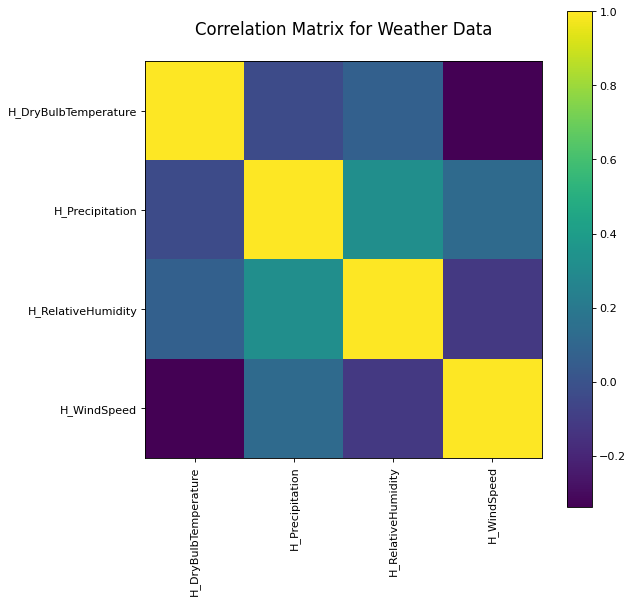

In [47]:
# Using dry bulb temperature here as this is the temperature most people refer to
corr_col = ['H_DryBulbTemperature','H_Precipitation','H_RelativeHumidity','H_WindSpeed']
plotCorrelationMatrix(slice_weather_df[corr_col], 8, 'Weather Data')

The correlation matrix shows the relationship between weather conditions:

- Temperature is negatively correlated with wind speed and slightly negatively correlated with precipitation and relative humidity.
- Precipitation is positively correlated with relative humidity, since rain will increase the relative humidity of the air.


In [52]:
weather_sky_conditions_df = weather_df[['Date','H_PresentWeatherType','H_SkyConditions']]
alt.data_transformers.disable_max_rows()
def weather_sky_bar():

  weather_type_chart = alt.Chart(weather_sky_conditions_df).mark_bar().encode(
      alt.X('H_PresentWeatherType:N',sort='-y',axis=alt.Axis(labelFontSize=12),title='Weather Types'),
      alt.Y('count():Q',title='Total Hour Counts')
  ).properties(height=300,width=200)

  sky_condition_chart = alt.Chart(weather_sky_conditions_df,height=500,width=300).mark_bar().encode(
      alt.X('H_SkyConditions:N',sort='-y',axis=alt.Axis(labelFontSize=12),title='Sky Conditions'),
      alt.Y('count():Q',title=None),
  ).properties(height=300,width=200)

  bar_chart = (weather_type_chart | sky_condition_chart).properties(
      title='Number of hours with specific weather/sky conditions'
      )

  return bar_chart

weather_sky_chart = weather_sky_bar()
weather_sky_chart

alt.HConcatChart(...)

The hourly weather and sky conditions from Jan to May in 2018 is captured in the above plots. The weather conditions in our dataset are majority clear, with lower rain and snow hourly reports. The sky conditions show similar counts of hourly clear skies and overcast.

In [54]:
monthly_cols = ['Date','H_DryBulbTemperature','H_Precipitation','H_RelativeHumidity','H_WindSpeed']
date_time = pd.to_datetime(weather_df['Date'])
monthly_grouped = (weather_df[monthly_cols]
                    .groupby([date_time.dt.month,date_time.dt.day,date_time.dt.hour]).mean()
                    .rename_axis(['Month','Day','Hour'])
                    .reset_index())
monthly_grouped;

## 3.2 Widget to show weather conditions at varying time intervals

In [56]:
output = widgets.Output()

month_dict = {'1': 'January',
              '2': 'February',
              '3': 'March',
              '4': 'April',
              '5': 'May'
             }

legend_scale = {'DryBulbTemperature': (-15,35),
                'Precipitation': (0,0.56),
                'RelativeHumidity': (0,100),
                'WindSpeed': (0,20)
               }

def temp_heatmap(ax='Month,Day',feature='DryBulbTemperature',month='all'):
  axis = ax.split(',')
  y_axis = axis[0] + ':O'
  x_axis = axis[1] + ':O'

  feature_name = feature
  if feature[0] != 'H':
    feature = 'H_' + feature + ':Q'

  if month =='all':
    month_df = monthly_grouped.copy()
    title  = f'Heat Map of the average {feature_name} from January to May'
  
  if month != 'all':
    month_num = int(month)
    month_df = monthly_grouped[monthly_grouped['Month'] == month_num]
    month_name = month_dict[month]
    title  = f'Heat Map of the average {feature_name} in {month_name}'

  scale_domain = legend_scale[feature_name]
  heat_map = alt.Chart(month_df).mark_rect().encode(
      alt.X(x_axis),
      alt.Y(y_axis),
      alt.Color(feature, 
                legend=alt.Legend(title=feature_name), 
                scale=alt.Scale(domain=scale_domain)
                ),
  ).properties(
      title=title
  )
  return heat_map

def clicked(b):
  output.clear_output()
  with output:
    _axis = datetimeradio.value
    _feature = featureradio.value
    _month = monthradio.value
    temp_heatmap(ax=_axis,feature=_feature,month=_month).display()

datetimeradio = widgets.RadioButtons(description='Datetimes:',options=['Month,Day','Day,Hour','Month,Hour'])
featureradio = widgets.RadioButtons(description='Features:',
                                   options=['DryBulbTemperature',
                                            'Precipitation',
                                            'RelativeHumidity',
                                            'WindSpeed'],
                                   value='DryBulbTemperature')
monthradio = widgets.RadioButtons(description='Months:',options=['all','1', '2', '3', '4', '5'],value='all')

datetimeradio.observe(clicked)
featureradio.observe(clicked)
monthradio.observe(clicked)

list_widgets = [widgets.HBox([featureradio,datetimeradio, monthradio])]
accordion = widgets.Accordion(children=list_widgets)
display(accordion,output)

Accordion(children=(HBox(children=(RadioButtons(description='Features:', options=('DryBulbTemperature', 'Preci…

Output()

This interactive heatmap shows quantitative weather features at different scales of date/time on the x and y axis, and a filter to see individual months.

# 4.Join the bike data to weather for correlation analysis

In [57]:
cursor = connection_cursor()

w_b_query = '''
  SELECT
  date_trunc('hour', j.date) as hour,
  count(j.num_bikes) as rides,
  ROUND(AVG(EXTRACT (HOUR FROM (j.stoptime - j.starttime)) * 60 + 
    EXTRACT (MINUTE FROM (j.stoptime - j.starttime)) +
    EXTRACT (SECOND FROM (j.stoptime - j.starttime)) / 60)::numeric,2) as duration_minutes,
  w.h_drybulbtemperature, w.h_precipitation, w.h_relativehumidity, w.h_visibility, w.h_windspeed
  FROM joined_rides_bikes as j
  JOIN weather as w
  ON j.date = w.date
  GROUP BY hour, w.h_drybulbtemperature, w.h_precipitation, w.h_relativehumidity, w.h_visibility, w.h_windspeed
  ORDER BY hour
'''

cursor.execute(w_b_query)
w_b_data = cursor.fetchall()
w_b_df = pd.DataFrame(w_b_data)
w_b_df.head()

,0,1,2,3,4,5,6,7
0,2018-01-01 00:00:00,146,9.82,9.0,0.0,55.0,10.0,9.0
1,2018-01-01 01:00:00,97,8.21,9.0,0.0,55.0,10.0,10.0
2,2018-01-01 02:00:00,59,9.01,8.0,0.0,57.0,10.0,10.0
3,2018-01-01 03:00:00,38,8.24,8.0,0.0,55.0,10.0,7.0
4,2018-01-01 04:00:00,15,5.98,8.0,0.0,55.0,10.0,9.0


In [58]:
w_b_df.columns = ['date','num_bikes','avg_duration','temperature','precipitation','rel_humidity','visibility','wind_speed']
w_b_df['avg_duration'] = w_b_df['avg_duration'].astype(float)
w_b_df.describe()

,num_bikes,avg_duration,temperature,precipitation,rel_humidity,visibility,wind_speed
count,4978.000000,4978.000000,4978.000000,4978.000000,4978.000000,4978.000000,4978.000000
mean,1084.567899,9.485241,45.798313,0.009444,67.760747,7.697670,5.383889
std,1138.147334,1.498978,14.456405,0.033175,22.582174,3.329428,4.105045
min,2.000000,3.150000,5.000000,0.000000,12.000000,0.000000,0.000000
25%,174.000000,8.570000,36.000000,0.000000,49.000000,5.000000,3.000000
50%,713.500000,9.365000,44.000000,0.000000,69.000000,10.000000,5.000000
75%,1610.000000,10.267500,56.000000,0.000000,90.000000,10.000000,8.000000
max,7446.000000,18.500000,92.000000,0.680000,100.000000,10.000000,21.000000


In [59]:
corr_cols = ['num_bikes','avg_duration','temperature','precipitation','rel_humidity','wind_speed']

corr_df = w_b_df[corr_cols]
corr_df;

In [60]:
scaled_corr_df = corr_df.copy()

min_max_scaler = MinMaxScaler()
scale_cols = ['temperature','precipitation','rel_humidity','wind_speed']
scaled_corr_df[scale_cols] = min_max_scaler.fit_transform(scaled_corr_df[scale_cols])
# scaled_corr_df['precipitation'] = scaled_corr_df['precipitation'].apply(lambda x: np.log(x) if x > 0 else 0)

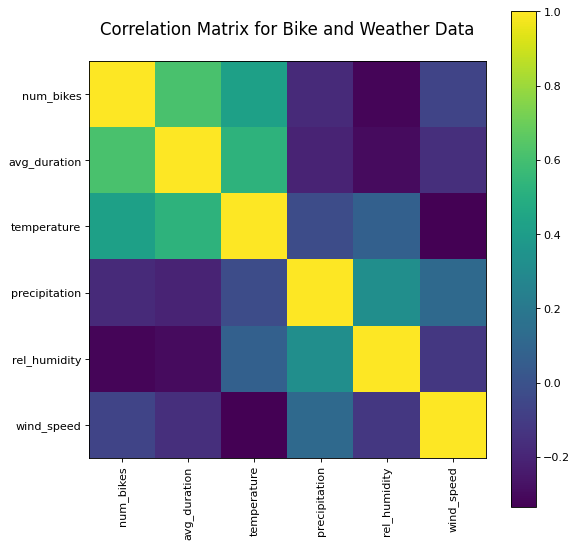

In [61]:
plotCorrelationMatrix(scaled_corr_df, 8, 'Bike and Weather Data')

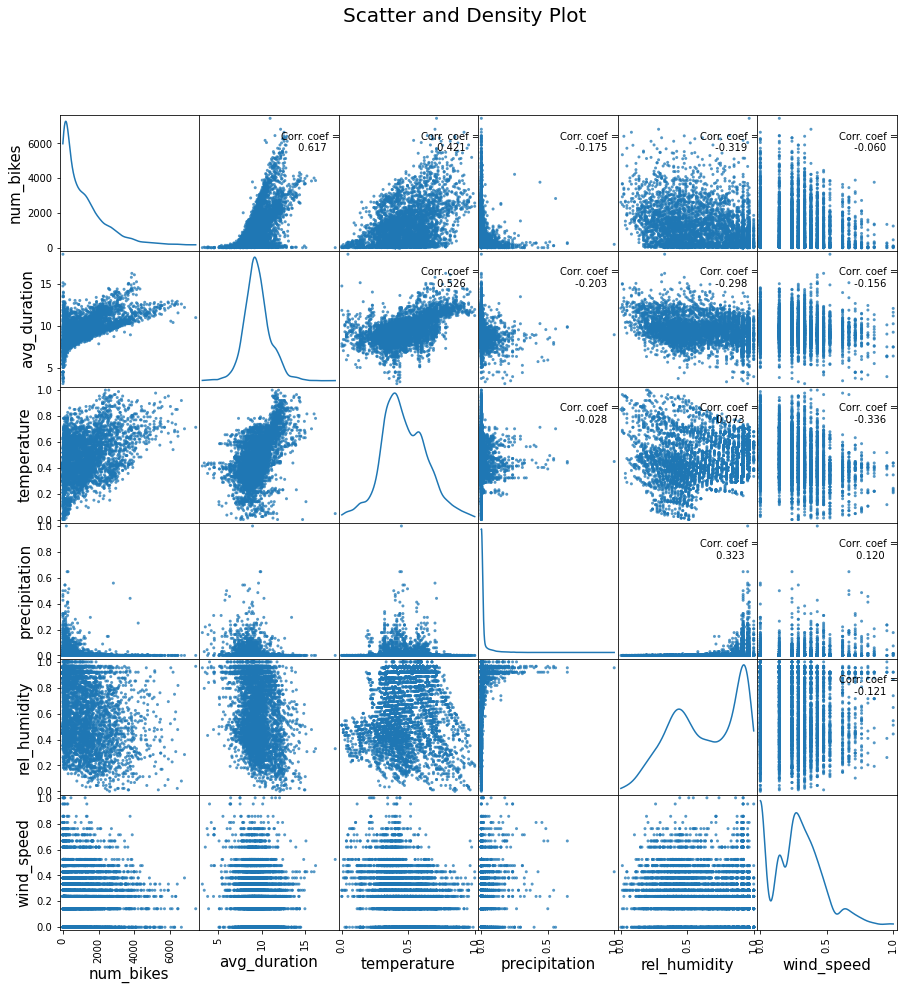

In [68]:
 plotScatterMatrix(scaled_corr_df, 15, 3)

There is a positive correlation between bike hires and ride durations to temperature, with a correlation coefficient of 0.42 and 0.52 respectively. The positive correlation was reflective of the increase in ridership during the month of may when the temperature was higher. The precipitation and humidity is negatively correlated with a correlation of (-0.18, -0.20) and (-0.32, -0.30) respectively to bike hires and ride duration. 


## 4.1 Count of bikes and weather type by hour

In [69]:
cursor = connection_cursor()

In [70]:
# Count sum of bike rides in each hour and the weather type for that hour
join_query = """
  select
  date_trunc('hour', date) as hour, -- or hour, day, week, month, year
  count(num_bikes) as rides,
  h_presentweathertype
  from joined_rides_bikes
  group by hour, h_presentweathertype
  order by hour
  """

cursor.execute(join_query)
joined_data = cursor.fetchall()
joined_df = pd.DataFrame(joined_data)
joined_df.head()

,0,1,2
0,2018-01-01 00:00:00,146,clear
1,2018-01-01 01:00:00,97,clear
2,2018-01-01 02:00:00,59,clear
3,2018-01-01 03:00:00,38,clear
4,2018-01-01 04:00:00,15,clear


The above makes the join, and sums the bikes per hour/weather condition

In [71]:
joined_df.columns = ["Time to nearest hour","Number of bikes hired", "Weather type"]

In [72]:
joined_df.sample(10)

,Time to nearest hour,Number of bikes hired,Weather type
1221,2018-02-18 03:00:00,55,clear
160,2018-01-07 14:00:00,434,clear
2188,2018-03-29 07:00:00,6983,clear
3023,2018-05-01 14:00:00,2617,clear
2903,2018-04-26 17:00:00,5697,clear
347,2018-01-14 20:00:00,324,clear
2087,2018-03-25 03:00:00,61,clear
1759,2018-03-11 04:00:00,51,clear
1668,2018-03-07 13:00:00,186,clear
1210,2018-02-17 19:00:00,278,clear


In [73]:
def scatter_bikes_hired(df= joined_df):
  chart = alt.Chart(df).mark_point(opacity=.5).encode(
      alt.X("Time to nearest hour:T"),
      alt.Y("Number of bikes hired:Q"),
      alt.Color('Weather type:N',scale=alt.Scale(range=['#2D7DD2','#FF476C','#A6C9C2']))
  ).properties(
      height = 400,
      width = 1100
  )
  return chart
scatter_bikes_hired()

alt.Chart(...)

- it may be better to smooth the above data, giving a moving average or trend line of hires for each hour. Plotting a trend line could be useful




In [123]:
# Taking all the above we can now create a function to produce the data
def summarize_hires_weather_type(df_in, weather_type = 'clear'):
  mask = (df_in['Weather type'] == weather_type)
  df_temp = df_in.loc[mask]
  df_out = df_temp.resample('D', on='Time to nearest hour').sum()
  remove_zeros = (df_out['Number of bikes hired'] > 0)
  df_out = df_out.loc[remove_zeros]
  return df_out.reset_index()

In [124]:
clear = summarize_hires_weather_type(joined_df)
snowy = summarize_hires_weather_type(joined_df, 'Snow')
rainy = summarize_hires_weather_type(joined_df, 'Rain')
snowy.shape

(16, 2)

In [82]:
clear_daily_ave = clear['Number of bikes hired'].mean()
snowy_daily_ave = snowy['Number of bikes hired'].mean()
rainy_daily_ave = rainy['Number of bikes hired'].mean()
vals = [clear_daily_ave, snowy_daily_ave, rainy_daily_ave]
weather = ['Clear', 'Snowy','Rainy']
print ([int(val) for val in vals])
df = pd.DataFrame(list(zip(vals,weather)) ,columns=['Daily average','Weather condition'])

df
alt.Chart(df).mark_bar().encode(alt.X('Weather condition:N'), alt.Y('Daily average:Q')
).properties(title = ['Average rides hired in','different weather conditions', 'Jan-May 2018'])

[33281, 4316, 4968]


alt.Chart(...)

In [83]:
snow_chart = alt.Chart(snowy).mark_point( 
    color ='#FF476C'
).encode(
      alt.X("Time to nearest hour:T", title="Day"),
      alt.Y("Number of bikes hired:Q")
  ).properties(
      height = 400,
      width = 1100
  ).properties(
    title='Count of bikes hired on days when it snowed'
)

In [84]:
clear_chart = alt.Chart(clear).mark_point( 
    color ='#2D7DD2'
).encode(
      alt.X("Time to nearest hour:T", title="Day"),
      alt.Y("Number of bikes hired:Q")
      #alt.Color('Weather type:N',scale=alt.Scale(range=['#2D7DD2','#FF476C','#A6C9C2']))
  ).properties(
      height = 400,
      width = 1100
  ).properties(
    title='Count of bikes hired on days when it neither rained nor snowed'
)

In [85]:
rain_chart = alt.Chart(rainy).mark_point( 
    color ='#A6C9C2'
).encode(
      alt.X("Time to nearest hour:T", title="Day"),
      alt.Y("Number of bikes hired:Q")
      #alt.Color('Weather type:N',scale=alt.Scale(range=['#2D7DD2','#FF476C','#A6C9C2']))
  ).properties(
      height = 400,
      width = 1100
  ).properties(
    title='Count of bikes hired on days when it rained'
)

In [86]:
clear_chart & snow_chart & rain_chart

alt.VConcatChart(...)

## 4.2 Average duration and weather type by hour

In [137]:
cursor = connection_cursor()

In [138]:
avg_dur_query = '''
  SELECT
  date_trunc('hour', date) as hour,
  ROUND(AVG(EXTRACT (HOUR FROM (stoptime - starttime)) * 60 + 
    EXTRACT (MINUTE FROM (stoptime - starttime)) +
    EXTRACT (SECOND FROM (stoptime - starttime)) / 60)::numeric,2) as duration_minutes,
  h_presentweathertype
  FROM joined_rides_bikes
  GROUP BY hour, h_presentweathertype
  ORDER BY hour
'''

cursor.execute(avg_dur_query)
avgdur_data = cursor.fetchall()
avgdur_df = pd.DataFrame(avgdur_data)
avgdur_df.head()

,0,1,2
0,2018-01-01 00:00:00,9.82,clear
1,2018-01-01 01:00:00,8.21,clear
2,2018-01-01 02:00:00,9.01,clear
3,2018-01-01 03:00:00,8.24,clear
4,2018-01-01 04:00:00,5.98,clear


In [128]:
avgdur_df.columns = ['Time to Nearest Hour', 'Avg Ride Duration (mins)', 'Weather Type']
avgdur_df['Avg Ride Duration (mins)'] = avgdur_df['Avg Ride Duration (mins)'].astype(float)
avgdur_df.sample(100)

,Time to Nearest Hour,Avg Ride Duration (mins),Weather Type
2244,2018-03-31 13:00:00,13.91,clear
3271,2018-05-11 21:00:00,11.91,clear
1399,2018-02-25 04:00:00,5.42,clear
3216,2018-05-09 15:00:00,11.58,clear
1265,2018-02-19 22:00:00,9.71,clear
...,...,...,...
406,2018-01-17 07:00:00,8.88,clear
1877,2018-03-15 20:00:00,9.45,clear
3394,2018-05-16 13:00:00,9.11,Rain
1407,2018-02-25 09:00:00,7.42,Rain


Plot of the avg duration with all of the weather types

In [129]:
# Plot of the avg duration with all of the weather types
scatter_duration_plot = alt.Chart(avgdur_df).mark_point(opacity=0.6).encode(
    alt.X('Time to Nearest Hour:T'),
    alt.Y('Avg Ride Duration (mins):Q'),
    alt.Color('Weather Type:N',scale=alt.Scale(range=['#2D7DD2','#FF476C','#A6C9C2']))
).properties(
    title='Average Ride Duration per Hour in Different Weather Conditions',
    width = 1000,
    height = 400
)
scatter_duration_plot

alt.Chart(...)

Bin ride duration by days and weather type

In [130]:
grouper = avgdur_df.groupby([pd.Grouper(key='Time to Nearest Hour', freq='1D'), 'Weather Type']).mean()
avg_dur_daily_df = (grouper.unstack()['Avg Ride Duration (mins)'].reset_index()
                            .rename({'Time to Nearest Hour': 'Days', 'clear': 'Clear'},axis=1)
                            .round(2))
avg_dur_daily_df

Weather Type,Days,Rain,Snow,Clear
0,2018-01-01,NaN,NaN,8.29
1,2018-01-02,NaN,NaN,8.42
2,2018-01-03,NaN,NaN,8.40
3,2018-01-04,NaN,9.49,9.95
4,2018-01-05,NaN,NaN,9.93
...,...,...,...,...
146,2018-05-27,8.65,NaN,10.49
147,2018-05-28,NaN,NaN,11.58
148,2018-05-29,NaN,NaN,11.10
149,2018-05-30,NaN,NaN,11.28


In [131]:
temp_df = avgdur_df.groupby([pd.Grouper(key='Time to Nearest Hour', freq='1D'), 'Weather Type']).mean()
temp_df.reset_index(inplace=True)
temp_df.rename({'Time to Nearest Hour': 'Days'},axis=1,inplace=True)
temp_df

,Days,Weather Type,Avg Ride Duration (mins)
0,2018-01-01,clear,8.291250
1,2018-01-02,clear,8.416250
2,2018-01-03,clear,8.397083
3,2018-01-04,Snow,9.495000
4,2018-01-04,clear,9.950000
...,...,...,...
223,2018-05-28,clear,11.580833
224,2018-05-29,clear,11.096250
225,2018-05-30,clear,11.284167
226,2018-05-31,Rain,9.820000


In [132]:
# Plot of the avg duration with all of the weather types
scatter_duration_plot = alt.Chart(temp_df).mark_point(opacity=0.6).encode(
    alt.X('Days:T'),
    alt.Y('Avg Ride Duration (mins):Q'),
    alt.Color('Weather Type:N',scale=alt.Scale(range=['#2D7DD2','#FF476C','#A6C9C2']))
).properties(
    title='Average Daily Ride Duration in Different Weather Conditions',
    width = 1000,
    height = 400
)
scatter_duration_plot

alt.Chart(...)

In [133]:
days_scale = avg_dur_daily_df['Days']

def to_altair_datetime(dt):
    dt = pd.to_datetime(dt)
    return alt.DateTime(year=dt.year, month=dt.month, date=dt.day,
                        hours=dt.hour, minutes=dt.minute, seconds=dt.second,
                        milliseconds=0.001 * dt.microsecond)

alt_days_scale = days_scale.apply(to_altair_datetime)

In [134]:
# Plot of the avg duration on hours where it is clear
clear_days_plot = alt.Chart(avg_dur_daily_df).mark_point(
    color='#4E7E75'
).encode(
    alt.X('Days:T',
          scale=alt.Scale(domain=list(alt_days_scale))),
    alt.Y('Clear:Q',
          scale=alt.Scale(domain=(0, 15)),
          title='Avg Ride Duration (mins)'),
    alt.Tooltip('Clear')
).properties(
    title='Average Ride Duration with Clear Days',
    width = 1000,
    height = 400
)

# Plot of the avg duration on hours where it is raining
rainy_days_plot = alt.Chart(avg_dur_daily_df).mark_point(
    color='#2D7DD2'
).encode(
    alt.X('Days:T',
          scale=alt.Scale(domain=list(alt_days_scale))),
    alt.Y('Rain:Q',
          scale=alt.Scale(domain=(0, 15)),
          title='Avg Ride Duration (mins)'),
    alt.Tooltip('Clear')
).properties(
    title='Average Ride Duration with Rainy Days',
    width = 1000,
    height = 400
)

# Plot of the avg duration on hours where it is raining
snowy_days_plot = alt.Chart(avg_dur_daily_df).mark_point(
    color='#FF476C'
).encode(
    alt.X('Days:T',
          scale=alt.Scale(domain=list(alt_days_scale))),
    alt.Y('Snow:Q',
          scale=alt.Scale(domain=(0, 15)),
          title='Avg Ride Duration (mins)'),
    alt.Tooltip('Clear')
).properties(
    title='Average Ride Duration with Snowy Days',
    width = 1000,
    height = 400
)
alt.vconcat(clear_days_plot, rainy_days_plot, snowy_days_plot)

alt.VConcatChart(...)